In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.maxent_irl_gridworld import main, run_maxent_irl

PARSER = argparse.ArgumentParser(description=None)
PARSER.add_argument('-hei', '--height', default=5, type=int, help='height of the gridworld')
PARSER.add_argument('-wid', '--width', default=5, type=int, help='width of the gridworld')
PARSER.add_argument('-g', '--gamma', default=0.8, type=float, help='discount factor')
PARSER.add_argument('-a', '--act_random', default=0.3, type=float, help='probability of acting randomly')
PARSER.add_argument('-t', '--n_trajs', default=100, type=int, help='number of expert trajectories')
PARSER.add_argument('-l', '--l_traj', default=20, type=int, help='length of expert trajectory')
PARSER.add_argument('--rand_start', dest='rand_start', action='store_true', help='when sampling trajectories, randomly pick start positions')
PARSER.add_argument('--no-rand_start', dest='rand_start',action='store_false', help='when sampling trajectories, fix start positions')
PARSER.set_defaults(rand_start=False)
PARSER.add_argument('-lr', '--learning_rate', default=0.01, type=float, help='learning rate')
PARSER.add_argument('-ni', '--n_iters', default=20, type=int, help='number of iterations')
PARSER.add_argument('-act', '--active', action='store_true', help='active learning setting')  # store true
PARSER.add_argument('-al', '--alpha', default=1.0, type=float, help='temperature parameter for value iteration')
PARSER.add_argument('-nq', '--n_query', default=1, type=int, help='number of queries to the expert(n_demonstrations)')
PARSER.add_argument('-rm', '--r_max', default=1, type=int, help='maximum reward value')
PARSER.add_argument('-er', '--error', default=0.01, type=float, help='error threshold for policy evaluation and value iteration')

def parse_args_str(args_str):
    args = PARSER.parse_args(args_str.split())
    return args

Baseline Settings: 

```python
COMMOM_ARGS = """
--height 5
--width 5
--gamma 0.8
--act_random 0.3
--n_trajs 400
--l_traj 15
--learning_rate 0.01
--n_iters 20
--alpha 0.25
--n_query 1
--r_max 1
--error 0.01
"""
```
* Alpha = 1.0 일때 exploitation 하는 경향이 있음
* Alpha = 0.1 일때 gamma 을 0.95 보다 높게 주면 MaxEnt IRL 시 value iteration에서 converge가 안됨..

In [134]:
COMMOM_ARGS = """
--height 5
--width 5
--gamma 0.8
--act_random 0.3
--n_trajs 400
--l_traj 5
--learning_rate 0.01
--n_iters 20
--alpha 0.25
--n_query 1
--r_max 1
--error 0.01
"""

In [135]:
# active learning setting
args = parse_args_str(COMMOM_ARGS + '--active')
print(args)
history_act = run_maxent_irl(args)

args = parse_args_str(COMMOM_ARGS)
print(args)
history_rand = run_maxent_irl(args)

Namespace(height=5, width=5, gamma=0.8, act_random=0.3, n_trajs=400, l_traj=5, rand_start=False, learning_rate=0.01, n_iters=20, active=True, alpha=0.25, n_query=1, r_max=1, error=0.01)
[INFO] Initialize Grid World
[INFO] Getting ground truth values and policy via value teration
[INFO] Initialize trajectories
[INFO] Trajectory length(Include inital starting point) = 6, First trajectories.
[Step(cur_state=23, action=2, next_state=23, reward=0.0, done=False), Step(cur_state=23, action=2, next_state=24, reward=0.0, done=False), Step(cur_state=24, action=2, next_state=24, reward=1.0, done=False), Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False), Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False), Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False)]
[INFO] Start Learning
[INFO - 00001 ] Training MaxEnt IRL
iteration: 0/20
iteration: 1/20
iteration: 2/20
iteration: 3/20
iteration: 4/20
iteration: 5/20
iteration: 6/20
iteration: 7/20
iterati

In [136]:
import pickle
with open('./exps/history_act-l_traj_5.pkl', 'wb') as file:
    pickle.dump(history_act, file)
with open('./exps/history_rand-l_traj_5.pkl', 'wb') as file:
    pickle.dump(history_rand, file)

---

In [137]:
def get_infos(history, active=False, search_idx=None):
    values_gt = history[0]['values_gt']
    idxs = list(history.keys())[1:-1]
    all_values_diff = {'mean': [], 'std': []}
    for i in idxs:
        vd_mean = np.abs(history[i]['values'] - values_gt).mean()
        vd_std = np.abs(history[i]['values'] - values_gt).std()
        all_values_diff['mean'].append(vd_mean)
        all_values_diff['std'].append(vd_std)
    
    if search_idx is None:
        search_idx = idxs[-1]
    else:
        if search_idx not in idxs:
            raise KeyError(f'last_idx should be in available idxs: {idxs}')

    info_dict = {
        'rewards_gt': history[0]['rewards_gt'],
        'values_gt': history[0]['values_gt'],
        'policy_gt': history[0]['policy_gt'],
        'rewards': history_act[search_idx]['rewards'],
        'trajs': history_act[0]['trajs'],
        'values': history_act[search_idx]['values'],
    }
    if active:
        info_dict['rewards_new_T'] = history_act[search_idx]['rewards_new_T']
        info_dict['values_new'] = history_act[search_idx]['values_new']
        info_dict['policy_new'] = history_act[search_idx]['policy_new']

    return idxs, all_values_diff, info_dict

def reshaper(args, data):
    return np.reshape(data, (args.height, args.width), order='F')

def draw_maps(info_dict, active=False, search_idx=None):
    fig, axes = plt.subplots(1, 4, figsize=(20, 4), dpi=110)
    titles = {
        'rewards_gt': 'Rewards Map (Ground Truth)',
        'values_gt': 'Value Map (Ground Truth)',
        'rewards': 'Rewards Map (Recovered)',
        'values': 'Value Map (Recovered)',
    }
    for (key, title), ax in zip(titles.items(), axes.flatten()):
        ax.set_title(title)
        sns.heatmap(reshaper(args, info_dict[key]), annot=True, fmt='.2f', ax=ax)

    suptitle = 'Active Sampling' if active else 'Random Sampling'
    if search_idx is not None:
        suptitle += f' (N_trajs={search_idx})'
    fig.suptitle(suptitle, fontsize=16)
    plt.tight_layout()
    plt.show()

def draw_acq_maps(info_dict, search_idx=None):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = {
        'rewards_gt': 'Rewards Map (Ground Truth)',
        'rewards_new_T': 'Rewards Map (Acquisition)',
        'rewards': 'Rewards Map (Recovered)',
    }
    for (key, title), ax in zip(titles.items(), axes.flatten()):
        ax.set_title(title)
        sns.heatmap(reshaper(args, info_dict[key]), annot=True, fmt='.2f', ax=ax)
    suptitle = 'Rewards Map Comparison '
    if search_idx is not None:
        suptitle += f' (N_trajs={search_idx}+1)'
    fig.suptitle(suptitle, fontsize=16)
    plt.tight_layout()
    plt.show()

def draw_evd(idxs_act, idxs_rand, vd_act, vd_rand, search_idx=None):
    title = 'Expected value difference'
    if search_idx is not None:
        title += f' (N_trajs={search_idx})'
    if search_idx is None:
        search_idx = len(idxs_act)
    vd_act_mean = np.array(vd_act['mean'])[:search_idx]
    vd_act_std = np.array(vd_act['std'])[:search_idx]
    vd_rand_mean = np.array(vd_rand['mean'])[:search_idx]
    vd_rand_std = np.array(vd_rand['std'])[:search_idx]
    idxs_act = idxs_act[:search_idx]
    idxs_rand = idxs_rand[:search_idx]

    fig, ax = plt.subplots(figsize=(8, 4))

    sns.lineplot(x=idxs_act, y=vd_act_mean, label='active')
    ax.fill_between(idxs_act, vd_act_mean - vd_act_std, vd_act_mean + vd_act_std, alpha=0.3)

    sns.lineplot(x=idxs_rand, y=vd_rand_mean, label='random')
    ax.fill_between(idxs_rand, vd_rand_mean - vd_rand_std, vd_act_mean + vd_rand_std, alpha=0.3)
    
    ax.set_xlabel('Number of acquistions samples')
    ax.set_ylabel('Expected value difference')
    
    ax.set_title(title)
    # ax.set_xticks(idxs_act)
    ax.legend()
    plt.show()

In [122]:
idxs_act, vd_act, info_act = get_infos(history_act, active=True, search_idx=None)
idxs_rand, vd_rand, info_rand = get_infos(history_rand, active=False, search_idx=None)

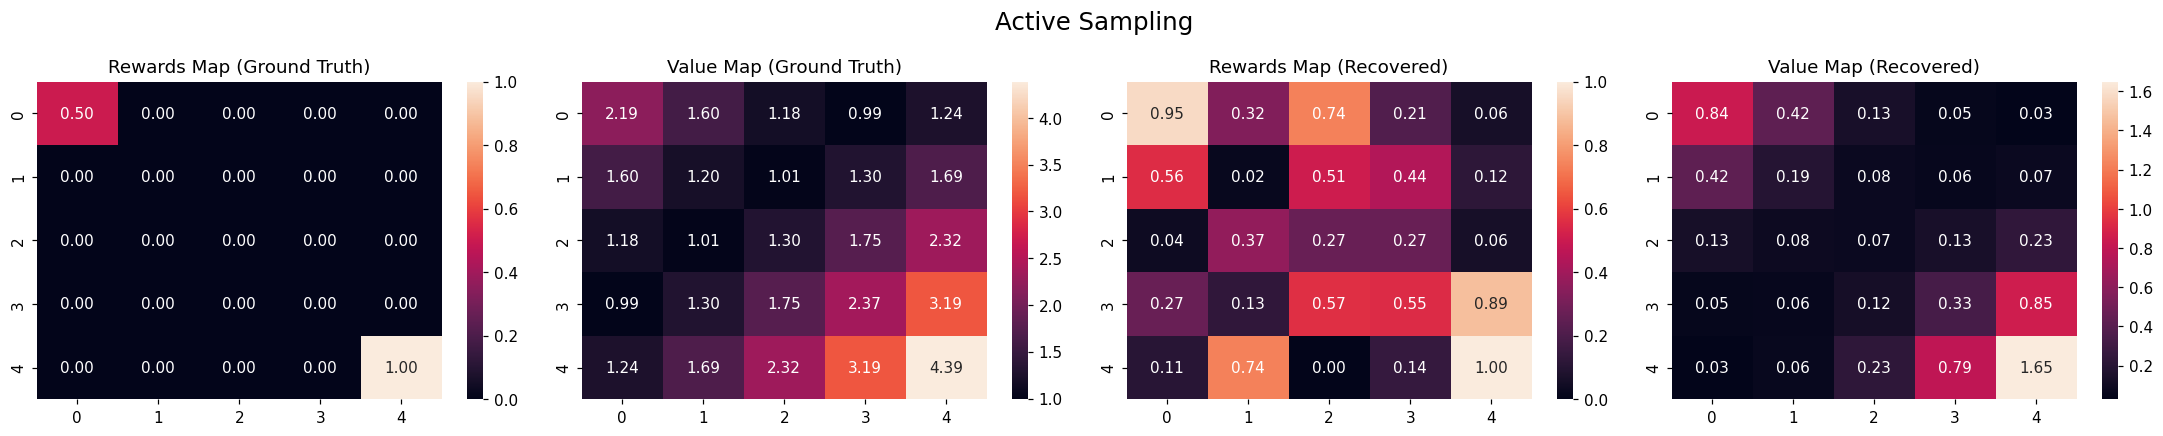

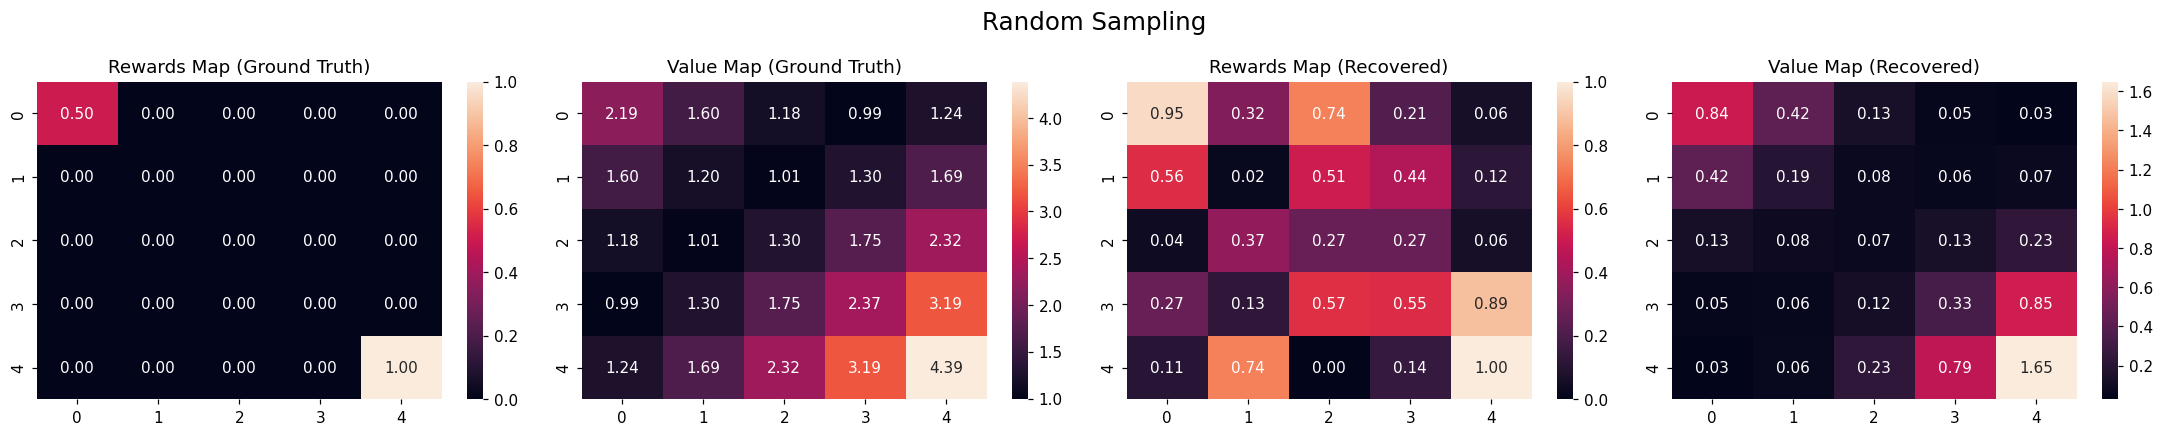

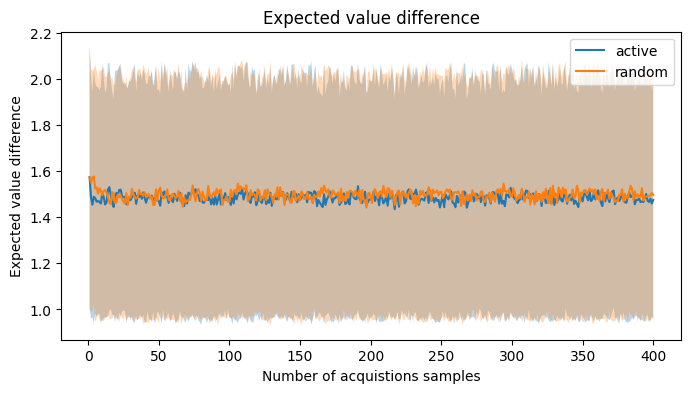

In [123]:
draw_maps(info_act, active=True, search_idx=None)
draw_maps(info_rand, active=False, search_idx=None)  # same to info_act
draw_evd(idxs_act, idxs_rand, vd_act, vd_rand, search_idx=None)

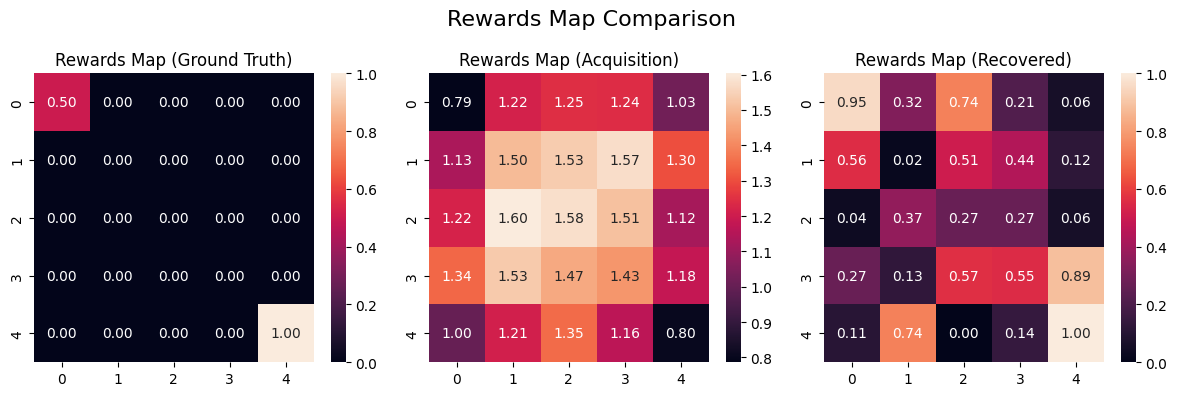

In [125]:
draw_acq_maps(info_act, search_idx=None)

In [126]:
search_idx = 1
idxs_act, vd_act, info_act = get_infos(history_act, active=True, search_idx=search_idx)
idxs_rand, vd_rand, info_rand = get_infos(history_rand, active=False, search_idx=search_idx)

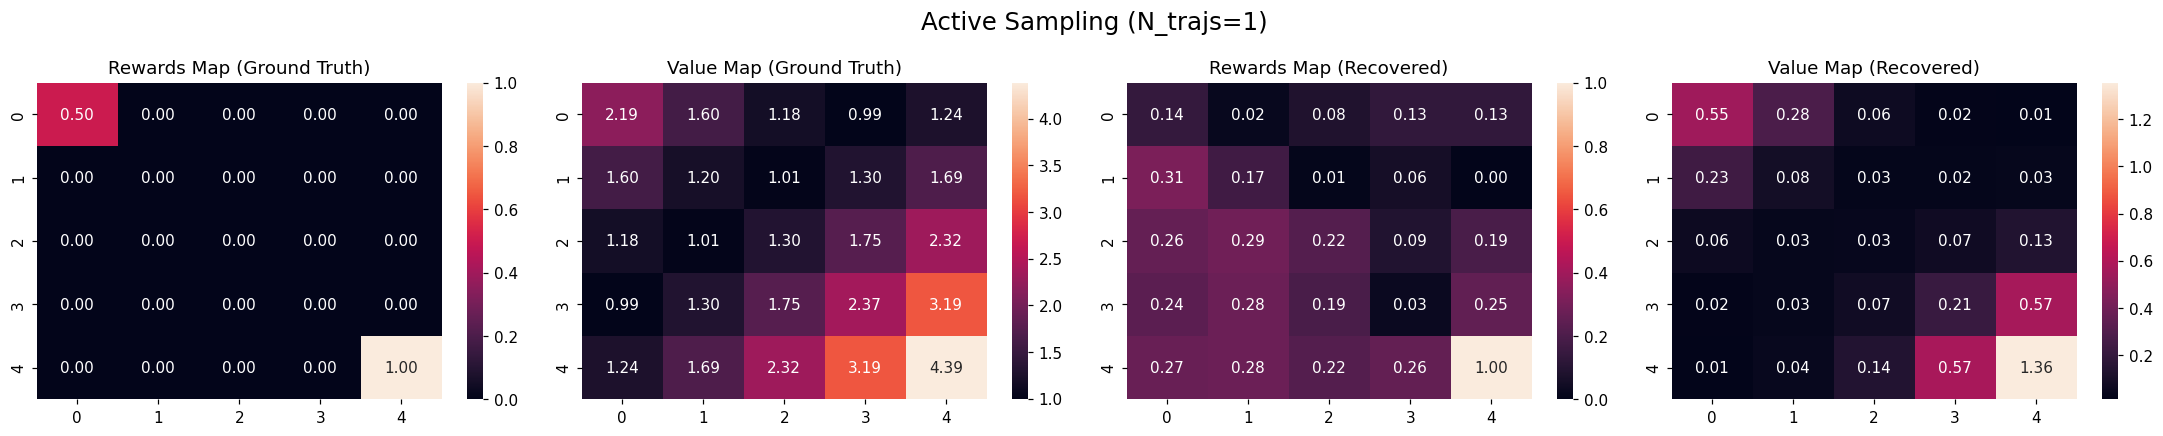

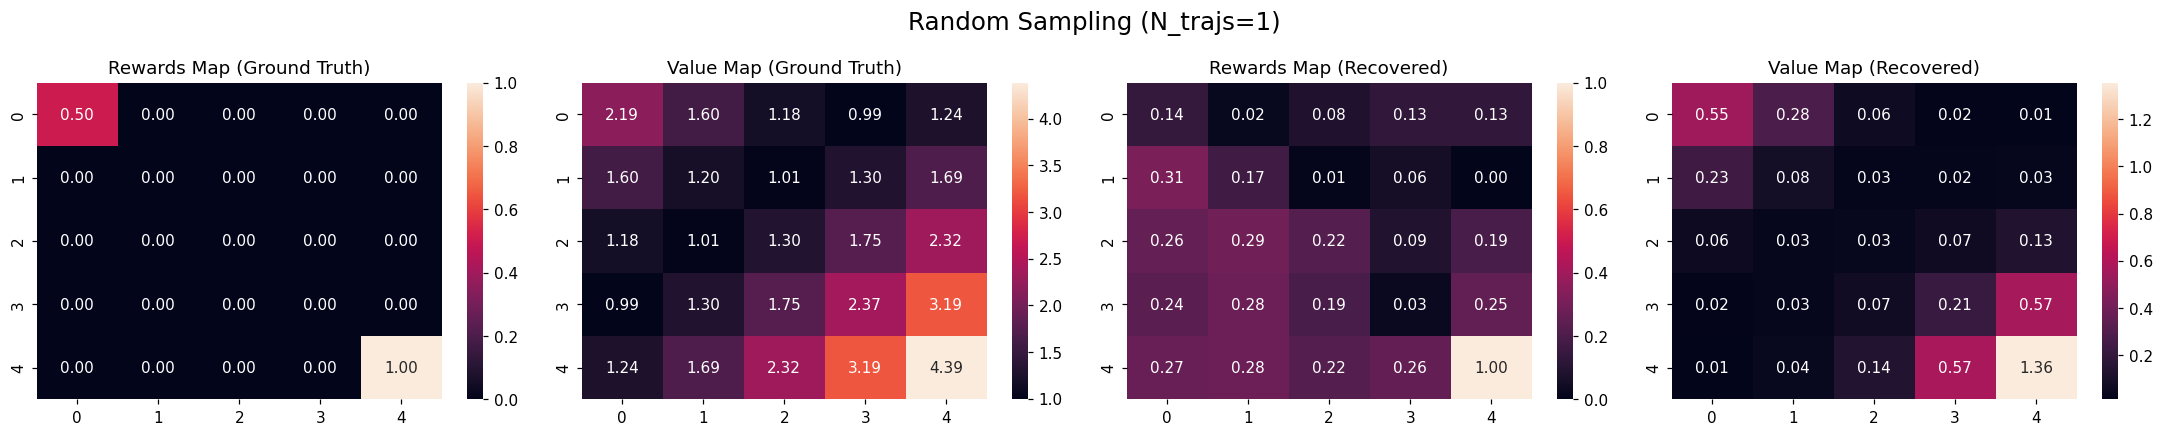

In [127]:
draw_maps(info_act, active=True, search_idx=search_idx)
draw_maps(info_rand, active=False, search_idx=search_idx)

In [132]:
for e in range(len(history_act[1]['trajs'])):
    print('Episode {}:'.format(e))
    for x in history_act[4]['trajs'][e][:5]:
        print(x)

Episode 0:
Step(cur_state=23, action=2, next_state=23, reward=0.0, done=False)
Step(cur_state=23, action=2, next_state=24, reward=0.0, done=False)
Step(cur_state=24, action=2, next_state=24, reward=1.0, done=False)
Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False)
Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False)
Episode 1:
Step(cur_state=2, action=3, next_state=1, reward=0.0, done=False)
Step(cur_state=1, action=3, next_state=0, reward=0.0, done=False)
Step(cur_state=0, action=3, next_state=1, reward=0.5, done=False)
Step(cur_state=1, action=1, next_state=1, reward=0.0, done=False)
Step(cur_state=1, action=3, next_state=2, reward=0.0, done=False)
Episode 2:
Step(cur_state=6, action=1, next_state=1, reward=0.0, done=False)
Step(cur_state=1, action=1, next_state=1, reward=0.0, done=False)
Step(cur_state=1, action=3, next_state=0, reward=0.0, done=False)
Step(cur_state=0, action=3, next_state=0, reward=0.5, done=False)
Step(cur_state=0, action=1, next_

In [133]:
for e in range(len(history_rand[1]['trajs'])):
    print('Episode {}:'.format(e))
    for x in history_rand[4]['trajs'][e][:5]:
        print(x)

Episode 0:
Step(cur_state=23, action=2, next_state=23, reward=0.0, done=False)
Step(cur_state=23, action=2, next_state=24, reward=0.0, done=False)
Step(cur_state=24, action=2, next_state=24, reward=1.0, done=False)
Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False)
Step(cur_state=24, action=0, next_state=24, reward=1.0, done=False)
Episode 1:
Step(cur_state=12, action=0, next_state=17, reward=0.0, done=False)
Step(cur_state=17, action=0, next_state=22, reward=0.0, done=False)
Step(cur_state=22, action=2, next_state=23, reward=0.0, done=False)
Step(cur_state=23, action=2, next_state=23, reward=0.0, done=False)
Step(cur_state=23, action=2, next_state=24, reward=0.0, done=False)
Episode 2:
Step(cur_state=21, action=2, next_state=21, reward=0.0, done=False)
Step(cur_state=21, action=2, next_state=22, reward=0.0, done=False)
Step(cur_state=22, action=2, next_state=23, reward=0.0, done=False)
Step(cur_state=23, action=2, next_state=24, reward=0.0, done=False)
Step(cur_state=